# Double inverted pendulum

In this Jupyter Notebook we illustrate the example **DIP**. This example illustrates how to use **DAE** models in **do-mpc**.

**Open an interactive online Jupyter Notebook with this content on Binder:**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/do-mpc/do-mpc.git/master?filepath=%2Fdocumentation%2Fsource%2Fexample_gallery%DIP.ipynb)


The example consists of the three modules **template_model.py**, which describes the system model, **template_mpc.py**, which defines the settings for the control and **template_simulator.py**, which sets the parameters for the simulator.
The modules are used in **main.py** for the closed-loop execution of the controller.

The example is special because it comes with two variants of the model one in **template_model_ode.py** and the other in **template_model_dae.py**. The difference is, as the name suggests, that the model is formulated as an ODE or DAE.

In this jupyter notebook we will **only focus on the DAE formulation** of the model.

We start by importing basic modules and **do-mpc**.

In [1]:
import numpy as np
import sys
from casadi import *

# Add do_mpc to path. This is not necessary if it was installed via pip
sys.path.append('../../../')

# Import do_mpc package:
import do_mpc

## Model

In the following we will present the configuration, setup and connection between these blocks, starting with the `model`. 

In this example we consider the double pendulum on a card as depicted below:


<img src="dip_sketch.svg" width="60%">

The system is described in terms of its horizontal position $x$ and the two angles $\theta$, where $\theta_1 = \theta_2 = 0$ denotes the upright position.

We will formulate a continuous dynamic model for this system and start by initiating a **do-mpc** ``Model`` instance:

In [2]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

### Parameters

The model is configured with the following (certain) parameters:

In [2]:
m0 = 0.6  # kg, mass of the cart
m1 = 0.2  # kg, mass of the first rod
m2 = 0.2  # kg, mass of the second rod
L1 = 0.5  # m,  length of the first rod
L2 = 0.5  # m,  length of the second rod
l1 = L1/2 # m,  
l2 = L2/2 # m,
J1 = (m1 * l1**2) / 3   # Inertia
J2 = (m2 * l2**2) / 3   # Inertia

g = 9.80665 # m/s^2, Gravity 

We furthermore introduce the following derived parameters to conveniently formulate the model equations below.

In [3]:
h1 = m0 + m1 + m2
h2 = m1*l1 + m2*L1
h3 = m2*l2
h4 = m1*l1**2 + m2*L1**2 + J1
h5 = m2*l2*L1
h6 = m2*l2**2 + J2
h7 = (m1*l1 + m2*L1) * g
h8 = m2*l2*g

### Euler-Lagrangian equations

The dynamics of the double pendulum can be derived from the Euler-Lagrangian equations, which yield:

\begin{align}
h_1\ddot{x}+h_2\ddot{\theta}_1\cos(\theta_1)+h_3\ddot{\theta}_2\cos(\theta_2)
&= (h_2\dot{\theta}_1^{2}\sin(\theta_1) + h_3\dot{\theta}_2^{2}\sin(\theta_2) + u)\\
h_2\cos(\theta_1)\ddot{x} + h_4\ddot{\theta}_1 + h_5\cos(\theta_1-\theta_2)\ddot{\theta}_2
&= (h_7\sin(\theta_1) - h_5\dot{\theta}_2^{2}\sin(\theta_1-\theta_2))\\
h_3\cos(\theta_2)\ddot{x} + h_5\cos(\theta_1-\theta_2)\ddot{\theta}_1 + h_6\ddot{\theta}_2
&= (h_5\dot{\theta}_1^{2}\sin(\theta_1-\theta_2) + h_8\sin(\theta_2))
\end{align}

we introduce the states

$$x=[x,\theta_1, \theta_2, \dot{x}, \dot{\theta}_1, \dot{\theta}_2]^T$$

and input:

$$ u = f$$

which is the horizontal force applied to the cart.

In [5]:
pos = model.set_variable('_x',  'pos')
theta = model.set_variable('_x',  'theta', (2,1))
dpos = model.set_variable('_x',  'dpos')
dtheta = model.set_variable('_x',  'dtheta', (2,1))

u = model.set_variable('_u',  'force')

**At this point we have two options.** The typical approach would be to rewrite the system as:

$$M(x) \dot x = A(x) x + B u$$

where it can be shown that 

$$ \det(M) > 0, \forall x$$

such that we can obtain the ODE:

$$\dot x = M(x)^{-1}(A(x)x + B u)$$

**do-mpc** fully supports this option but it requires some nasty reformulations of the above equations and yields a very complex expression for the ODE. For the sake of completeness, this formulation is included in the example files (``template_model_ode.py``).

Instead we suggest ...

### Differential algebraic equation (DAE)

We introduce new algebraic states 

$$ z=[\ddot{x}, \ddot{\theta}_1, \ddot{\theta}_2]^T$$

In [6]:
ddpos = model.set_variable('_z', 'ddpos')
ddtheta = model.set_variable('_z', 'ddtheta', (2,1))

which makes it very convenient to formulate the ODE in terms of $x,u,z$:

$$ \dot{x} = [\dot{x}, \dot{\theta}_1, \dot{\theta}_2, \ddot{x}, \ddot{\theta}_1, \ddot{\theta}_2]^T$$

In [7]:
model.set_rhs('pos', dpos)
model.set_rhs('theta', dtheta)
model.set_rhs('dpos', ddpos)
model.set_rhs('dtheta', ddtheta)

The only remaining challenge is to implement the relationship between $x,u$ and $z$, in the form of:

$$g(x,u,z)=0$$

with **do-mpc** this is easily achieved:

In [8]:
euler_lagrange = vertcat(
        # 1
        h1*ddpos+h2*ddtheta[0]*cos(theta[0])+h3*ddtheta[1]*cos(theta[1])
        - (h2*dtheta[0]**2*sin(theta[0]) + h3*dtheta[1]**2*sin(theta[1]) + u),
        # 2
        h2*cos(theta[0])*ddpos + h4*ddtheta[0] + h5*cos(theta[0]-theta[1])*ddtheta[1]
        - (h7*sin(theta[0]) - h5*dtheta[1]**2*sin(theta[0]-theta[1])),
        # 3
        h3*cos(theta[1])*ddpos + h5*cos(theta[0]-theta[1])*ddtheta[0] + h6*ddtheta[1]
        - (h5*dtheta[0]**2*sin(theta[0]-theta[1]) + h8*sin(theta[1]))
    )

model.set_alg('euler_lagrange', euler_lagrange)

with just a few lines of code we have defined the dynamics of the double pendulum!

### Energy equations

The next step is to introduce new "auxiliary" expressions to **do-mpc** for the kinetic and potential energy of the system. This is required in this example, because we will need these expressions for the formulation of the MPC controller. 

Introducing these expressions has the additional advantage that **do-mpc** saves and exports the calculated values, which is great for monitoring and debugging.

For the kinetic energy, we have:

\begin{align}
E_{\text{kin.,cart}} &= \frac{1}{2}  m  \dot{x}^{2}\\
E_{\text{kin.,}p_1} &= \frac{1}{2}  m_1  (
    (\dot{x} + l_1  \dot{\theta}_1  \cos(\theta_1))^{2} +
    (l_1  \dot{\theta}_1  \sin(\theta_1))^{2}) + \frac{1}{2}  J_1  \dot{\theta}_1^{2}\\
E_{\text{kin,}p_2} &= \frac{1}{2}  m_2  (
    (\dot{x} + L_1  \dot{\theta}_1  \cos(\theta_1) + l_2  \dot{\theta}_2  \cos(\theta_2))^{2} +
    (L_1  \dot{\theta}_1  \sin(\theta_1) + l_2  \dot{theta}_2  \sin(\theta_2))^2) + \frac{1}{2}  J_2  \dot{\theta}_1^{2}
\end{align}

and for the potential energy:

$$
E_{\text{pot.}} = m_1 g  l_1 \cos(
    \theta_1) + m_2 g (L_1 \cos(\theta_1) +
                                l_2 \cos(\theta_2))
$$

It only remains to formulate the expressions and set them to the model:

In [9]:
E_kin_cart = 1 / 2 * m0 * dpos**2
E_kin_p1 = 1 / 2 * m1 * (
    (dpos + l1 * dtheta[0] * cos(theta[0]))**2 +
    (l1 * dtheta[0] * sin(theta[0]))**2) + 1 / 2 * J1 * dtheta[0]**2
E_kin_p2 = 1 / 2 * m2 * (
    (dpos + L1 * dtheta[0] * cos(theta[0]) + l2 * dtheta[1] * cos(theta[1]))**2 +
    (L1 * dtheta[0] * sin(theta[0]) + l2 * dtheta[1] * sin(theta[1]))**
    2) + 1 / 2 * J2 * dtheta[0]**2

E_kin = E_kin_cart + E_kin_p1 + E_kin_p2

E_pot = m1 * g * l1 * cos(
theta[0]) + m2 * g * (L1 * cos(theta[0]) +
                            l2 * cos(theta[1]))

model.set_expression('E_kin', E_kin)
model.set_expression('E_pot', E_pot)

SX(((0.490333*cos(theta_0))+(1.96133*((0.5*cos(theta_0))+(0.25*cos(theta_1))))))

Finally, the model setup is completed:

In [10]:
# Build the model
model.setup()

## Controller


Next, the controller is configured.
First, an instance of the mpc class is generated with the prediction model defined above:

In [12]:
mpc = do_mpc.controller.MPC(model)

We choose the prediction horizon `n_horizon=100`, set the robust horizon `n_robust` to 0. The time step `t_step` is set to $0.04s$ and parameters of the applied discretization scheme orthogonal collocation are as seen below:

In [13]:
setup_mpc = {
    'n_horizon': 100,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.04,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 1,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

### Objective

The control objective is to errect the double pendulum and to stabilize it in the up-up position. It is not straight-forward to formulate an objective which yields this result. Classical set-point tracking, e.g. with a quadratic cost: 

$$
\theta_s = [0,0,0]
$$

and formulating:

$$
J = \sum_{k=0}^N (\theta-\theta_s)^2
$$

is **known to work very poorly**. Clearly, the problem results from the fact that $
\theta_s = 2\pi n,\ n\in \mathbb{Z}$ is also a valid solution. 

Instead we will use an energy-based formulation for the objective. If we think of energy in terms of potential and kinetic energy it is clear that we want to maximize the potential energy (up-up position) and minimize the kinetic energy (stabilization). Implicitly, this is also penalizes excessively large input forces which is always a good idea!

Since we have already introduced the expressions for the potential and kinetic energy in the model, we can now simply reuse these expresssions for the fomulation of the objective function, as shown below:

In [14]:
mterm = model.aux['E_kin'] - model.aux['E_pot'] # stage cost
lterm = model.aux['E_kin'] - model.aux['E_pot'] # terminal cost

mpc.set_objective(mterm=mterm, lterm=lterm)
# Input force is implicitly restricted through the objective.
mpc.set_rterm(force=0.0)

### Constraints

In the next step, the constraints of the control problem are set.
In this case, there is only an upper and lower bounds for the input.

In [15]:
mpc.bounds['lower','_u','force'] = -4
mpc.bounds['upper','_u','force'] = 4

We can now setup the controller.

In [16]:
mpc.setup()

## Estimator

We assume, that all states can be directly measured (state-feedback):

In [15]:
estimator = do_mpc.estimator.StateFeedback(model)

## Simulator

To create a simulator in order to run the MPC in a closed-loop, we create an instance of the **do-mpc** simulator which is based on the same model:

In [16]:
simulator = do_mpc.simulator.Simulator(model)

For the simulation, we use the time step `t_step` as for the optimizer:

In [17]:
params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'idas',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.04
}

simulator.set_param(**params_simulator)

In [18]:
simulator.setup()

## Closed-loop simulation

For the simulation of the MPC configured for the DIP, we inspect the file **main.py**.
We define the initial state of the system and set for all parts of the closed-loop configuration:

In [19]:
simulator.x0['theta'] = 0.99*np.pi

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

NameError: name 'mpc' is not defined

Note that ``mpc.set_initial_guess()`` is very important in this example. Also note that we didn't set the initial state at exactly $\pi$ which results in unfavorable numerical issues (it will work however).

### Prepare visualization

For the visualization of the control performance, we first import matplotlib and change some basic settings:

In [20]:
import matplotlib.pyplot as plt
plt.ion()
from matplotlib import rcParams
rcParams['text.usetex'] = False
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['axes.labelsize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

We use the plotting capabilities, which are included in **do-mpc**.
The `mpc_graphics` contain information like the current estimated state and the predicted trajectory of the states and inputs based on the solution of the control problem.
The `sim_graphics` contain the information about the simulated evaluation of the system.

In [22]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

For the example of the DIP we create a new function which takes as input the states (at a give time $k$) and returns the x and y positions of the two bars (the arms of the pendulum).

In [21]:
def pendulum_bars(x):
    x = x.flatten()
    # Get the x,y coordinates of the two bars for the given state x.
    line_1_x = np.array([
        x[0],
        x[0]+L1*np.sin(x[1])
    ])

    line_1_y = np.array([
        0,
        L1*np.cos(x[1])
    ])

    line_2_x = np.array([
        line_1_x[1],
        line_1_x[1] + L2*np.sin(x[2])
    ])

    line_2_y = np.array([
        line_1_y[1],
        line_1_y[1] + L2*np.cos(x[2])
    ])

    line_1 = np.stack((line_1_x, line_1_y))
    line_2 = np.stack((line_2_x, line_2_y))

    return line_1, line_2

We then setup a graphic:

In [45]:
%%capture

fig = plt.figure(figsize=(12,8))

ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=4)
ax2 = plt.subplot2grid((4, 2), (0, 1))
ax3 = plt.subplot2grid((4, 2), (1, 1),sharex=ax2)
ax4 = plt.subplot2grid((4, 2), (2, 1),sharex=ax2)
ax5 = plt.subplot2grid((4, 2), (3, 1),sharex=ax2)

ax2.set_ylabel('$E_{kin}$ [J]')
ax3.set_ylabel('$E_{pot}$ [J]')
ax4.set_ylabel('Angle  [rad]')
ax5.set_ylabel('Input force [N]')

# Axis on the right.
for ax in [ax2, ax3, ax4, ax5]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax4:
        ax.xaxis.set_ticklabels([])
        
ax5.set_xlabel('time [s]')

mpc_graphics.add_line(var_type='_aux', var_name='E_kin', axis=ax2)
mpc_graphics.add_line(var_type='_aux', var_name='E_pot', axis=ax3)
mpc_graphics.add_line(var_type='_x', var_name='theta', axis=ax4)
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax5)

ax1.axhline(0,color='black')

bar1 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar2 = ax1.plot([],[], '-o', linewidth=5, markersize=10)

ax1.set_xlim(-1,1)
ax1.set_ylim(-1,1)
ax1.set_axis_off()

fig.align_ylabels()
fig.tight_layout()

### Run open-loop

Before we test the closed loop case, lets plot one open-loop prediction to check how the resulting graphic looks like.

In [37]:
u0 = mpc.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    13206
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5115

Total number of variables............................:     3424
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equa

  92  1.7279081e+02 4.52e-02 5.34e-02  -5.7 2.66e+01  -4.1 4.92e-02 7.71e-03h  1
  93  1.7250178e+02 5.42e-02 5.59e-02  -5.7 1.91e+02  -4.5 8.58e-03 4.12e-02f  1
  94  1.7236013e+02 5.08e-02 5.22e-02  -5.7 2.96e+01  -4.1 3.20e-01 9.40e-02f  1
  95  1.7174615e+02 1.31e-01 9.81e-02  -5.7 6.22e+02  -4.6 3.73e-02 4.07e-02f  1
  96  1.7173184e+02 1.30e-01 9.73e-02  -5.7 5.42e+01  -4.2 5.04e-02 7.89e-03h  1
  97  1.7173096e+02 1.30e-01 9.73e-02  -5.7 1.77e+03  -4.6 6.59e-03 2.61e-05h  1
  98  1.7159629e+02 1.23e-01 9.34e-02  -5.7 6.17e+01  -4.2 8.77e-03 7.69e-02f  1
  99  1.7158780e+02 1.23e-01 9.34e-02  -5.7 1.30e+04  -4.7 5.30e-04 3.15e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7142120e+02 1.15e-01 9.05e-02  -5.7 6.40e+01  -4.3 4.05e-02 8.90e-02f  1
 101  1.7123470e+02 8.40e-02 6.66e-02  -5.7 1.78e+01  -3.8 2.52e-01 2.96e-01h  1
 102  1.7095836e+02 8.15e-02 7.08e-02  -5.7 6.58e+01  -4.3 4.10e-02 1.46e-01h  1
 103  1.7086697e+02 6.62e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.5809375e+02 2.28e-02 1.71e-02  -5.7 2.27e+01  -4.1 5.03e-02 1.18e-01h  1
 201  1.5801310e+02 2.30e-02 1.71e-02  -5.7 8.81e+01  -4.6 2.52e-02 5.83e-02h  1
 202  1.5792044e+02 2.13e-02 1.55e-02  -5.7 2.75e+01  -4.2 3.18e-01 1.94e-01h  1
 203  1.5779142e+02 2.95e-02 1.69e-02  -5.7 1.18e+02  -4.7 7.21e-02 8.43e-02h  1
 204  1.5777007e+02 2.82e-02 1.85e-02  -5.7 3.39e+01  -4.2 4.81e-01 4.25e-02h  1
 205  1.5747124e+02 8.69e-02 4.45e-02  -5.7 1.45e+02  -4.7 6.52e-02 1.81e-01h  1
 206  1.5740121e+02 7.84e-02 3.88e-02  -5.7 4.54e+01  -4.3 4.24e-01 1.22e-01h  1
 207  1.5735675e+02 7.84e-02 3.81e-02  -5.7 2.21e+02  -4.8 5.30e-02 1.86e-02h  1
 208  1.5729003e+02 7.28e-02 3.42e-02  -5.7 5.34e+01  -4.3 8.70e-01 1.00e-01h  1
 209  1.5718431e+02 7.96e-02 3.35e-02  -5.7 3.51e+02  -4.8 2.35e-02 2.81e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.5684529e+02 1.26e-01

 292  1.4594932e+02 2.23e-01 9.78e-02  -5.7 1.68e+02  -4.7 9.08e-03 2.30e-02h  1
 293  1.4592916e+02 2.17e-01 9.52e-02  -5.7 4.17e+01  -4.2 1.94e-01 2.66e-02h  1
 294  1.4571448e+02 2.18e-01 8.71e-02  -5.7 2.32e+02  -4.7 2.26e-02 6.16e-02h  1
 295  1.4569119e+02 2.12e-01 8.47e-02  -5.7 5.26e+01  -4.3 4.76e-02 2.67e-02h  1
 296  1.4549789e+02 2.02e-01 7.63e-02  -5.7 1.79e+02  -4.8 1.15e-01 7.32e-02h  1
 297  1.4533256e+02 1.63e-01 5.75e-02  -5.7 4.62e+01  -4.3 8.48e-02 2.15e-01f  1
 298  1.4497309e+02 1.58e-01 4.70e-02  -5.7 1.84e+02  -4.8 4.99e-02 1.42e-01h  1
 299  1.4450784e+02 2.05e-01 1.41e-01  -5.7 8.00e+02  -5.3 1.33e-02 3.85e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.4436284e+02 2.02e-01 1.47e-01  -5.7 2.10e+02  -4.9 9.40e-02 4.64e-02h  1
 301  1.4427415e+02 1.84e-01 1.34e-01  -5.7 6.84e+01  -4.4 1.26e-01 9.86e-02h  1
 302  1.4427315e+02 1.84e-01 1.34e-01  -5.7 1.29e+03  -4.9 6.66e-03 7.01e-05h  1
 303  1.4417805e+02 1.69e-01

 399  1.2667509e+02 1.72e-01 8.61e-02  -5.7 2.76e+02  -5.1 3.43e-02 3.85e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.2640915e+02 1.72e-01 7.98e-02  -5.7 1.17e+02  -4.7 2.18e-02 1.54e-01f  1
 401  1.2593498e+02 1.98e-01 2.08e-01  -5.7 1.70e+03  -5.2 4.80e-03 2.17e-02f  1
 402  1.2541219e+02 4.35e-01 3.22e-01  -5.7 9.53e+03  -4.8 9.24e-07 4.66e-03f  1
 403  1.2495263e+02 1.90e-01 3.95e-01  -5.7 4.55e+01  -4.3 2.62e-01 9.32e-01h  1
 404  1.2495260e+02 1.90e-01 3.95e-01  -5.7 3.05e+03  -4.8 1.86e-03 1.31e-06h  1
 405  1.2452459e+02 1.53e-01 3.12e-01  -5.7 4.25e+01  -4.4 3.19e-01 4.50e-01f  1
 406  1.2441702e+02 1.49e-01 2.93e-01  -5.7 1.01e+02  -4.9 1.06e-01 5.91e-02h  1
 407  1.2438818e+02 1.48e-01 2.92e-01  -5.7 5.03e+02  -5.4 2.60e-02 4.33e-03h  1
 408  1.2415146e+02 1.50e-01 3.00e-01  -5.7 1.00e+05  -5.8 7.87e-06 2.50e-04f  1
 409  1.2402743e+02 1.48e-01 2.95e-01  -5.7 9.19e+02  -5.4 2.60e-02 1.52e-02h  1
iter    objective    inf_pr 

 502  1.0766778e+02 1.85e-01 7.53e-02  -5.7 8.28e+01  -4.6 3.32e-01 1.47e-01h  1
 503  1.0757590e+02 1.85e-01 8.66e-02  -5.7 1.30e+03  -5.1 3.91e-05 6.98e-03f  1
 504  1.0750083e+02 1.76e-01 8.52e-02  -5.7 1.11e+02  -4.7 2.67e-01 5.78e-02h  1
 505  1.0723047e+02 7.80e-02 3.79e-02  -5.7 3.59e+01  -4.2 1.48e-01 6.68e-01h  1
 506  1.0713550e+02 7.33e-02 3.63e-02  -5.7 1.41e+02  -4.7 1.51e-01 5.74e-02h  1
 507  1.0710622e+02 6.85e-02 5.66e-02  -5.7 4.38e+01  -4.3 7.55e-01 6.49e-02h  1
 508  1.0617156e+02 8.50e-01 3.14e-01  -5.7 1.82e+02  -4.8 1.06e-01 5.63e-01f  1
 509  1.0608831e+02 8.12e-01 3.00e-01  -5.7 1.45e+02  -4.3 1.09e-01 4.84e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510  1.0600187e+02 6.54e-01 2.38e-01  -5.7 4.25e+01  -3.9 2.89e-01 1.95e-01h  1
 511  1.0588284e+02 5.22e-01 1.76e-01  -5.7 7.82e+01  -4.4 2.27e-01 2.05e-01h  1
 512  1.0539539e+02 5.97e-01 2.14e-01  -5.7 4.67e+02  -4.9 4.50e-04 1.15e-01h  1
 513  1.0510031e+02 6.36e-01

 595  8.9767495e+01 2.48e-01 3.49e-01  -5.7 2.81e+02  -4.7 2.60e-01 7.65e-02h  1
 596  8.9627742e+01 1.95e-01 2.34e-01  -5.7 4.65e+01  -4.3 5.13e-01 2.81e-01h  1
 597  8.9415313e+01 2.31e-01 2.49e-01  -5.7 3.44e+02  -4.8 1.14e-01 5.72e-02h  1
 598  8.9209616e+01 2.02e-01 2.08e-01  -5.7 6.41e+01  -4.4 4.01e-02 2.70e-01h  1
 599  8.9194831e+01 1.97e-01 2.03e-01  -5.7 4.61e+01  -4.8 2.33e-01 2.75e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  8.9066174e+01 1.70e-01 1.81e-01  -5.7 7.50e+01  -5.3 3.02e-02 1.56e-01h  1
 601  8.9044955e+01 1.64e-01 1.75e-01  -5.7 7.25e+01  -5.8 3.05e-01 3.57e-02h  1
 602  8.8997253e+01 1.65e-01 1.85e-01  -5.7 5.76e+02  -5.4 3.34e-06 1.32e-02h  1
 603  8.8949454e+01 1.58e-01 1.88e-01  -5.7 1.46e+02  -4.9 1.88e-01 5.53e-02h  1
 604  8.8855073e+01 1.61e-01 2.42e-01  -5.7 4.94e+02  -5.4 2.03e-02 3.42e-02h  1
 605  8.8835172e+01 1.56e-01 2.38e-01  -5.7 1.33e+02  -5.0 1.55e-02 2.89e-02h  1
 606  8.8792426e+01 1.35e-01

The first optimization will take rather long but in the end we get:

```
EXIT: Optimal Solution Found.
```

which tells us that we found an optimal solution. We can now visualize it with:

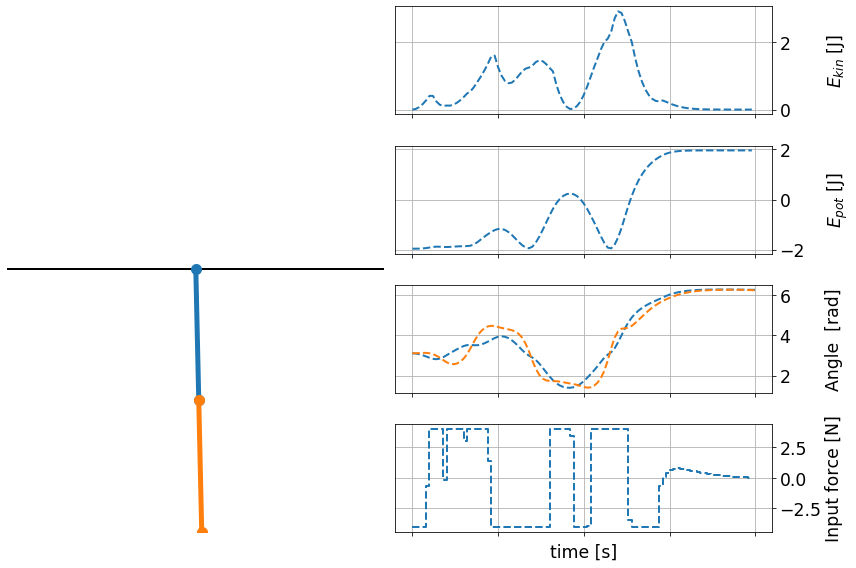

In [46]:
line1, line2 = pendulum_bars(x0)
bar1[0].set_data(line1[0],line1[1])
bar2[0].set_data(line2[0],line2[1])
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig

The open-loop prediction looks perfectly fine! We see that within the horizon the potential energy settles on a plateau greater than zero, while the kinetic energy becomes zero. This indicates our desired up-up position. Both angles seem to reach $2\pi$.

### Run closed-loop

The closed-loop system is now simulated for 100 steps (and the ouput of the optimizer is suppressed):

In [47]:
%%capture
# Quickly reset the history of the MPC data object.
mpc.reset_history()

n_steps = 100
for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

### Results

The next cell converts the results of the closed-loop MPC simulation into a gif (might take a few minutes):

In [53]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

# The function describing the gif:
x_arr = mpc.data['_x']
def update(t_ind):
    line1, line2 = pendulum_bars(x_arr[t_ind])
    bar1[0].set_data(line1[0],line1[1])
    bar2[0].set_data(line2[0],line2[1])
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()
    

anim = FuncAnimation(fig, update, frames=n_steps, repeat=False)
gif_writer = ImageMagickWriter(fps=10)
anim.save('anim_dip.gif', writer=gif_writer)

The result is shown below, where solid lines are the recorded trajectories and dashed lines are the predictions of the scenarios:

![animdip](anim_dip.gif "dip")

## Controller with obstacle avoidance

### Obstacle

In [4]:
obstacles = [
    {'x': 0.9, 'y': 0.5, 'r': 0.1}
]

### Model

In [5]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [6]:
pos = model.set_variable('_x',  'pos')
theta = model.set_variable('_x',  'theta', (2,1))
dpos = model.set_variable('_x',  'dpos')
dtheta = model.set_variable('_x',  'dtheta', (2,1))

u = model.set_variable('_u',  'force')

In [7]:
ddpos = model.set_variable('_z', 'ddpos')
ddtheta = model.set_variable('_z', 'ddtheta', (2,1))

In [8]:
model.set_rhs('pos', dpos)
model.set_rhs('theta', dtheta)
model.set_rhs('dpos', ddpos)
model.set_rhs('dtheta', ddtheta)

In [9]:
euler_lagrange = vertcat(
        # 1
        h1*ddpos+h2*ddtheta[0]*cos(theta[0])+h3*ddtheta[1]*cos(theta[1])
        - (h2*dtheta[0]**2*sin(theta[0]) + h3*dtheta[1]**2*sin(theta[1]) + u),
        # 2
        h2*cos(theta[0])*ddpos + h4*ddtheta[0] + h5*cos(theta[0]-theta[1])*ddtheta[1]
        - (h7*sin(theta[0]) - h5*dtheta[1]**2*sin(theta[0]-theta[1])),
        # 3
        h3*cos(theta[1])*ddpos + h5*cos(theta[0]-theta[1])*ddtheta[0] + h6*ddtheta[1]
        - (h5*dtheta[0]**2*sin(theta[0]-theta[1]) + h8*sin(theta[1]))
    )

model.set_alg('euler_lagrange', euler_lagrange)

### Energy Equations

In [10]:
E_kin_cart = 1 / 2 * m0 * dpos**2
E_kin_p1 = 1 / 2 * m1 * (
    (dpos + l1 * dtheta[0] * cos(theta[0]))**2 +
    (l1 * dtheta[0] * sin(theta[0]))**2) + 1 / 2 * J1 * dtheta[0]**2
E_kin_p2 = 1 / 2 * m2 * (
    (dpos + L1 * dtheta[0] * cos(theta[0]) + l2 * dtheta[1] * cos(theta[1]))**2 +
    (L1 * dtheta[0] * sin(theta[0]) + l2 * dtheta[1] * sin(theta[1]))**
    2) + 1 / 2 * J2 * dtheta[0]**2

E_kin = E_kin_cart + E_kin_p1 + E_kin_p2

E_pot = m1 * g * l1 * cos(
theta[0]) + m2 * g * (L1 * cos(theta[0]) +
                            l2 * cos(theta[1]))

model.set_expression('E_kin', E_kin)
model.set_expression('E_pot', E_pot)

SX(((0.490333*cos(theta_0))+(1.96133*((0.5*cos(theta_0))+(0.25*cos(theta_1))))))

Coordinates of the two nodes:

In [11]:
node0_x = model.x['pos']+L1*sin(model.x['theta',0])
node0_y = model.x['pos']+L1*cos(model.x['theta',0])

node1_x = node0_x+L2*sin(model.x['theta',1])
node1_y = node0_y+L2*cos(model.x['theta',1])

In [12]:
e = []

for obs in obstacles:
#     phi0 = tan((node0_y-obs['y'])/(node0_x-obs['x']))
#     alpha0 = np.pi/2 - phi0 - model.x['theta', 0]
#     d0 = sqrt(node0_x**2+node0_y**2)
#     e0 = sin(alpha0)*d0 - obs['r']
    
#     phi1 = tan((node1_y-obs['y'])/(node1_x-obs['x']))
#     alpha1 = np.pi/2 - phi1 - model.x['theta', 0]
#     d1 = sqrt(node1_x**2+node1_y**2)
#     e1 = sin(alpha1)*d1 - obs['r']
    
#     e.extend([e0, e1])

    d0 = sqrt((node0_x-obs['x'])**2+(node0_y-obs['y'])**2)
    d1 = sqrt((node1_x-obs['x'])**2+(node1_y-obs['y'])**2)
    
#     e0 = L1-d0*cos(model.x['theta',0])
#     e1 = L2-d1*cos(model.x['theta',1])

    alpha = arctan((node0_y-obs['y'])/(node0_x-obs['x']))
    gamma = np.pi/2-model.x['theta',0] - alpha
    e0 = cos(gamma)*d0
    
    e.extend([e0])

In [13]:
model.set_expression('e_obstacle', vertcat(*e))

SX(@1=0.5, @2=(pos+(@1*cos(theta_0))), @3=(pos+(@1*sin(theta_0))), @4=0.9, (cos(((1.5708-theta_0)-atan(((@2-@1)/(@3-@4)))))*sqrt((sq((@3-@4))+sq((@2-@1))))))

In [14]:
# Build the model
model.setup()

### Controller

In [43]:
mpc = do_mpc.controller.MPC(model)

In [44]:
setup_mpc = {
    'n_horizon': 100,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.04,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 1,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

In [45]:
mterm = model.aux['E_kin'] - model.aux['E_pot'] # stage cost
lterm = model.aux['E_kin'] - model.aux['E_pot'] # terminal cost

mpc.set_objective(mterm=mterm, lterm=lterm)
# Input force is implicitly restricted through the objective.
mpc.set_rterm(force=0.0)

In [46]:
mpc.bounds['lower','_u','force'] = -4
mpc.bounds['upper','_u','force'] = 4

In [47]:
mpc.set_nl_cons('obstacle_distance', model.aux['e_obstacle'], ub=0)

SX(@1=0.5, @2=(pos+(@1*cos(theta_0))), @3=(pos+(@1*sin(theta_0))), @4=0.9, (cos(((1.5708-theta_0)-atan(((@2-@1)/(@3-@4)))))*sqrt((sq((@3-@4))+sq((@2-@1))))))

In [48]:
mpc.setup()

### Graphic

In [49]:
from matplotlib.patches import Circle

In [50]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

In [51]:
%%capture

fig = plt.figure(figsize=(12,8))

ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 1),sharex=ax2)
ax4 = plt.subplot2grid((3, 2), (2, 1),sharex=ax2)

ax2.set_ylabel('offset')
ax3.set_ylabel('Angle  [rad]')
ax4.set_ylabel('Input force [N]')

# Axis on the right.
for ax in [ax2, ax3, ax4]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax4:
        ax.xaxis.set_ticklabels([])
        
ax4.set_xlabel('time [s]')

mpc_graphics.add_line(var_type='_aux', var_name='e_obstacle', axis=ax2)
mpc_graphics.add_line(var_type='_x', var_name='theta', axis=ax3)
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax4)

ax1.axhline(0,color='black')

bar1 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar2 = ax1.plot([],[], '-o', linewidth=5, markersize=10)

for obs in obstacles:
    circle = Circle((obs['x'], obs['y']), obs['r'])
    ax1.add_artist(circle)
    

ax1.set_xlim(-1,1)
ax1.set_ylim(-1,1)
ax1.set_axis_off()

fig.align_ylabels()
fig.tight_layout()

In [52]:
simulator.reset_history()
simulator.x0['theta'] = 0.99*np.pi

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

In [53]:
u0 = mpc.make_step(x0)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    13206
Number of nonzeros in inequality constraint Jacobian.:      200
Number of nonzeros in Lagrangian Hessian.............:     5315

Total number of variables............................:     3424
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3306
Total number of inequality constraints...............:      100
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      100

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.7411003e+02 1.01e-01 1.11e+01  -3.8 2.93e+01  -4.0 2.38e-02 8.86e-03h  1
  91  1.7391008e+02 9.87e-02 1.09e+01  -3.8 1.36e+02  -4.5 6.74e-02 4.25e-02f  1
  92  1.7388210e+02 9.74e-02 1.01e+01  -3.8 4.82e+01  -4.1 3.33e-02 1.91e-02h  1
  93  1.7380958e+02 9.67e-02 1.00e+01  -3.8 2.13e+02  -4.5 9.90e-03 1.19e-02h  1
  94  1.7367012e+02 9.36e-02 9.34e+00  -3.8 6.59e+01  -4.1 6.31e-02 6.81e-02h  1
  95  1.7360406e+02 8.93e-02 8.52e+00  -3.8 2.68e+01  -3.7 9.97e-02 8.85e-02h  1
  96  1.7334475e+02 8.08e-02 1.11e+01  -3.8 4.48e+01  -4.2 1.06e-01 1.60e-01h  1
  97  1.7332650e+02 7.99e-02 1.23e+01  -3.8 2.78e+01  -3.7 8.96e-02 2.03e-02h  1
  98  1.7318518e+02 1.24e-01 1.57e+01  -3.8 7.12e+01  -4.2 1.98e-02 6.43e-02h  1
  99  1.7311687e+02 1.21e-01 1.46e+01  -3.8 2.77e+01  -3.8 1.66e-01 7.24e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7308829e+02 1.18e-01

 196  1.6178002e+02 1.87e-01 6.10e+01  -3.8 1.12e+02  -4.0 1.24e-01 7.30e-02h  1
 197  1.6166725e+02 1.87e-01 5.91e+01  -3.8 3.21e+02  -4.5 1.76e-02 2.41e-02h  1
 198  1.6166409e+02 1.86e-01 5.19e+01  -3.8 1.82e+02  -4.1 8.51e-02 2.89e-03h  1
 199  1.6142878e+02 2.08e-01 4.65e+01  -3.8 3.98e+02  -4.5 1.16e-02 3.69e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.6138407e+02 2.07e-01 4.51e+01  -3.8 6.26e+02  -5.0 3.94e-03 6.47e-03h  1
 201  1.6123185e+02 2.04e-01 5.49e+01  -3.8 3.49e+02  -4.6 9.02e-02 2.11e-02h  1
 202  1.6122712e+02 2.03e-01 4.81e+01  -3.8 2.08e+02  -4.2 9.21e-02 1.83e-03h  1
 203  1.6122406e+02 2.03e-01 5.68e+01  -3.8 4.69e+02  -4.7 4.53e-02 3.30e-04h  1
 204  1.6080285e+02 2.47e-01 6.45e+01  -3.8 2.95e+02  -4.2 1.52e-02 1.05e-01f  1
 205  1.6078636e+02 2.45e-01 6.81e+01  -3.8 2.21e+02  -3.8 4.38e-03 1.38e-02h  1
 206  1.6049876e+02 2.53e-01 5.90e+01  -3.8 1.64e+02  -4.3 2.77e-02 1.09e-01h  1
 207  1.6028298e+02 2.51e-01

 304  1.5401485e+02 4.47e-01 3.80e+01  -3.8 6.81e+02  -7.7 1.32e-02 2.15e-02h  1
 305  1.5401072e+02 4.46e-01 4.43e+01  -3.8 1.05e+03  -8.2 1.40e-02 1.99e-03h  1
 306  1.5404528e+02 4.43e-01 4.02e+01  -3.8 8.38e+02  -8.6 4.11e-03 1.82e-02h  1
 307  1.5412204e+02 4.37e-01 5.32e+01  -3.8 7.23e+02  -9.1 2.10e-02 1.83e-02h  2
 308  1.5417698e+02 4.31e-01 5.23e+01  -3.8 1.14e+03  -9.6 2.52e-03 1.82e-02h  1
 309  1.5426962e+02 4.27e-01 5.18e+01  -3.8 4.27e+02  -4.7 2.12e-02 1.07e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  1.5428726e+02 4.26e-01 5.17e+01  -3.8 2.55e+02  -4.2 2.09e-02 2.03e-03h  5
 311  1.5443980e+02 4.18e-01 5.07e+01  -3.8 3.68e+02  -4.7 3.72e-03 1.85e-02h  2
 312  1.5445187e+02 4.17e-01 5.06e+01  -3.8 1.74e+03  -5.2 9.90e-03 1.96e-03h  2
 313  1.5448389e+02 4.15e-01 5.04e+01  -3.8 8.34e+02  -4.8 2.20e-04 4.09e-03h  1
 314  1.5448567e+02 4.15e-01 5.04e+01  -3.8 4.17e+02  -5.2 5.14e-02 2.93e-04h  7
 315  1.5448608e+02 4.15e-01

 406  1.5686001e+02 7.29e-02 4.51e+02  -3.8 3.97e+01  -2.2 3.44e-02 1.25e-02h  1
 407  1.5721363e+02 6.71e-02 2.54e+02  -3.8 4.03e+01  -2.6 3.66e-02 7.91e-02h  1
 408  1.5747929e+02 6.40e-02 1.64e+02  -3.8 2.65e+01  -2.2 2.92e-02 4.65e-02h  1
 409  1.5798926e+02 5.76e-02 2.12e+02  -3.8 5.56e+01  -2.7 2.56e-02 1.03e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  1.5810788e+02 5.62e-02 2.74e+02  -3.8 2.83e+01  -2.3 9.26e-03 2.43e-02h  1
 411  1.5819235e+02 5.53e-02 1.57e+02  -3.8 2.49e+01  -1.8 2.26e-02 1.55e-02h  1
 412  1.5834734e+02 5.38e-02 4.97e+03  -3.8 4.31e+01  -2.3 3.25e-02 2.71e-02h  1
 413  1.5847706e+02 5.21e-02 4.80e+03  -3.8 3.86e+01  -2.8 1.38e-01 3.31e-02h  1
 414  1.5900964e+02 4.78e-02 4.39e+03  -3.8 3.39e+01  -2.4 6.83e-02 8.65e-02h  1
 415  1.5977222e+02 4.27e-02 3.90e+03  -3.8 3.06e+01  -1.9 1.16e-02 1.12e-01h  1
 416  1.5912596e+02 1.47e-02 3.09e+03  -3.8 7.17e+00  -2.4 3.33e-04 6.50e-01f  1
 417  1.5899892e+02 1.36e-02

 512  1.3996504e+02 6.84e-01 6.00e+01  -3.8 1.07e+02  -4.5 3.61e-02 8.88e-02f  1
 513  1.3937996e+02 6.03e-01 5.66e+01  -3.8 5.90e+02  -5.0 8.63e-03 5.61e-02h  1
 514  1.3920145e+02 5.75e-01 5.42e+01  -3.8 1.68e+02  -4.5 2.31e-02 4.38e-02h  1
 515  1.3919080e+02 5.52e-01 5.20e+01  -3.8 5.72e+01  -4.1 1.39e-02 4.00e-02h  1
 516  1.3910074e+02 5.44e-01 5.13e+01  -3.8 1.77e+02  -4.6 8.67e-03 1.34e-02h  1
 517  1.3906500e+02 5.32e-01 5.01e+01  -3.8 7.12e+01  -4.2 1.09e-02 2.29e-02h  1
 518  1.3895539e+02 5.25e-01 4.95e+01  -3.8 2.01e+02  -4.6 3.94e-02 1.28e-02h  1
 519  1.3891575e+02 4.97e-01 4.69e+01  -3.8 7.49e+01  -4.2 3.61e-02 5.27e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  1.3888121e+02 4.95e-01 4.67e+01  -3.8 3.61e+02  -4.7 1.39e-02 3.81e-03h  1
 521  1.3863943e+02 4.71e-01 4.45e+01  -3.8 2.97e+02  -4.3 2.16e-02 4.89e-02f  1
 522  1.3806699e+02 4.35e-01 4.14e+01  -3.8 3.55e+02  -4.7 7.14e-02 7.40e-02f  1
 523  1.3780882e+02 4.21e-01

 624  1.2463139e+02 3.30e-01 2.74e+01  -3.8 5.27e+03  -5.5 1.30e-03 4.15e-03f  1
 625  1.2461957e+02 3.30e-01 2.73e+01  -3.8 4.64e+02  -5.1 2.96e-02 1.57e-03h  1
 626  1.2455505e+02 3.23e-01 2.68e+01  -3.8 2.51e+02  -4.7 3.28e-02 2.03e-02h  1
 627  1.2440121e+02 3.19e-01 2.66e+01  -3.8 1.35e+03  -5.2 1.52e-03 6.54e-03f  1
 628  1.2421143e+02 3.01e-01 2.53e+01  -3.8 2.53e+02  -4.7 5.03e-03 4.71e-02h  1
 629  1.2425231e+02 3.00e-01 2.53e+01  -3.8 1.14e+03  -5.2 1.88e-03 2.34e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630  1.2419904e+02 2.95e-01 2.49e+01  -3.8 2.31e+02  -4.8 2.16e-02 1.42e-02h  1
 631  1.2412697e+02 2.92e-01 2.47e+01  -3.8 7.04e+02  -5.3 5.76e-03 7.51e-03h  1
 632  1.2398933e+02 2.77e-01 2.37e+01  -3.8 2.06e+02  -4.8 2.07e-02 4.22e-02h  1
 633  1.2380634e+02 2.72e-01 2.35e+01  -3.8 2.41e+03  -5.3 7.17e-03 5.97e-03f  1
 634  1.2373123e+02 2.66e-01 2.32e+01  -3.8 3.76e+02  -4.9 1.32e-01 1.54e-02h  1
 635  1.2356274e+02 2.55e-01

 727  1.1056311e+02 3.60e-01 6.02e+01  -3.8 5.64e+03  -5.0 3.26e-03 2.41e-03f  1
 728  1.1040045e+02 3.43e-01 5.77e+01  -3.8 2.81e+02  -4.6 1.21e-02 4.12e-02h  1
 729  1.1028986e+02 3.39e-01 4.13e+01  -3.8 1.11e+03  -5.1 7.22e-02 6.73e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730  1.1005480e+02 3.28e-01 3.58e+01  -3.8 6.98e+03  -5.6 6.15e-03 2.47e-03f  1
 731  1.0987895e+02 3.17e-01 2.64e+01  -3.8 8.24e+02  -5.1 9.24e-02 1.36e-02f  1
 732  1.0860450e+02 6.95e-01 3.46e+01  -3.8 3.71e+03  -5.6 7.27e-03 2.40e-02f  1
 733  1.0859745e+02 6.94e-01 3.34e+01  -3.8 1.64e+03  -5.2 1.34e-02 3.11e-04h  1
 734  1.0814239e+02 6.81e-01 3.06e+01  -3.8 2.99e+02  -4.7 5.77e-02 8.39e-02f  1
 735  1.0801070e+02 6.43e-01 2.90e+01  -3.8 8.44e+01  -4.3 6.38e-02 5.76e-02h  1
 736  1.0774620e+02 6.35e-01 2.77e+01  -3.8 3.96e+02  -4.8 3.14e-02 4.03e-02h  1
 737  1.0761616e+02 6.04e-01 2.68e+01  -3.8 1.32e+02  -4.4 7.11e-02 5.50e-02h  1
 738  1.0756600e+02 6.03e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 840  9.4269374e+01 9.48e-01 4.02e+01  -3.8 2.67e+03 -12.9 1.10e-03 1.63e-02f  1
 841  9.4206917e+01 9.42e-01 3.87e+01  -3.8 7.60e+02 -13.4 2.14e-02 6.17e-03h  1
 842  9.3774584e+01 9.12e-01 3.53e+01  -3.8 9.89e+02 -13.9 7.13e-02 3.46e-02h  1
 843  9.3596910e+01 8.91e-01 3.48e+01  -3.8 7.30e+02 -14.3 3.97e-03 1.68e-02h  1
 844  9.3322746e+01 8.41e-01 3.61e+01  -3.8 3.01e+02 -14.8 1.56e-02 4.81e-02h  1
 845  9.3242607e+01 8.25e-01 3.58e+01  -3.8 2.90e+02 -15.3 1.60e-02 1.87e-02h  1
 846  9.2871781e+01 7.56e-01 3.16e+01  -3.8 3.89e+02 -15.8 6.27e-02 4.38e-02h  1
 847  9.2874611e+01 7.55e-01 3.40e+01  -3.8 7.19e+02 -16.2 4.05e-02 2.47e-04h  1
 848  9.2597589e+01 6.94e-01 4.20e+01  -3.8 3.10e+02 -16.7 5.31e-04 4.98e-02f  1
 849  9.2494362e+01 6.72e-01 4.07e+01  -3.8 2.40e+02  -4.9 3.15e-02 3.11e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850  9.2487011e+01 6.69e-01

 946  8.7570172e+01 1.13e-01 1.79e+00  -3.8 3.04e+01 -19.1 6.86e-03 9.90e-03h  1
 947  8.7561885e+01 1.13e-01 2.07e+01  -3.8 1.69e+02 -19.6 1.20e-02 1.48e-03h  1
 948  8.7505070e+01 1.12e-01 3.14e+01  -3.8 2.56e+02 -19.1 1.14e-02 7.44e-03f  1
 949  8.7069105e+01 1.06e-01 1.54e+02  -3.8 3.08e+02 -19.6 2.27e-03 5.62e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950  8.6939186e+01 1.04e-01 1.04e+02  -3.8 3.32e+02 -19.1 2.49e-02 1.61e-02h  1
 951  8.6844424e+01 1.03e-01 1.69e+01  -3.8 3.26e+02 -19.6 3.34e-02 1.33e-02h  1
 952  8.6820677e+01 1.03e-01 2.93e+02  -3.8 6.06e+02 -19.1 3.11e-02 2.51e-03h  1
 953  8.6559025e+01 9.88e-02 5.61e+01  -3.8 6.44e+02 -19.6 4.93e-06 3.59e-02f  1
 954  8.6549101e+01 9.87e-02 1.81e+02  -3.8 8.19e+02 -19.1 2.13e-02 1.54e-03h  1
 955  8.6134970e+01 1.09e+00 2.32e+02  -3.8 1.43e+03 -19.6 6.81e-03 7.67e-02f  1
 956  8.6172641e+01 1.08e+00 3.67e+02  -3.8 9.52e+02 -19.1 2.24e-02 3.47e-02h  1
 957r 8.6172641e+01 1.08e+00

1044r 9.3451106e+01 1.70e-01 7.94e+02  -0.7 1.27e+01    -  6.91e-04 9.49e-02f  1
1045r 9.3458767e+01 9.79e-02 7.37e+02  -0.7 2.47e+00    -  5.67e-02 7.26e-02f  1
1046r 9.3752972e+01 2.38e-02 8.52e+02  -0.7 5.82e+00    -  1.74e-01 4.52e-01f  1
1047r 9.3628954e+01 2.43e-02 8.08e+02  -0.7 4.24e+00    -  1.34e-01 5.10e-02f  1
1048r 9.3628759e+01 2.43e-02 8.08e+02  -0.7 2.23e+01    -  2.55e-02 8.86e-04h  1
1049r 9.3452414e+01 2.10e-02 7.79e+02  -0.7 6.59e+01    -  4.83e-03 3.56e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050r 9.3365971e+01 2.21e-02 7.73e+02  -0.7 2.90e+01    -  5.02e-02 7.43e-03h  1
1051r 9.3361047e+01 1.72e-01 1.18e+03  -0.7 1.73e+01    -  1.13e-03 7.00e-02f  1
1052r 9.3357374e+01 1.74e-01 1.12e+03  -0.7 5.00e+00    -  6.65e-02 5.54e-02f  1
1053r 9.3422567e+01 1.75e-01 1.10e+03  -0.7 1.33e+01    -  1.15e-01 1.26e-02f  1
1054r 9.3403065e+01 1.75e-01 1.09e+03  -0.7 2.93e+00    -  6.38e-01 1.36e-02h  1
1055r 9.3269007e+01 1.74e-01

1147r 9.1314031e+01 7.50e-02 1.44e+03  -0.8 1.20e+01    -  9.89e-02 1.58e-03h  1
1148r 8.9440673e+01 1.41e-01 1.33e+03  -0.8 1.35e+01    -  9.83e-04 2.11e-01h  1
1149r 8.9877331e+01 1.43e-01 1.16e+03  -0.8 6.52e+00    -  1.61e-01 1.29e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150r 8.9880489e+01 1.43e-01 1.16e+03  -0.8 2.86e+00    -  7.11e-02 1.23e-03h  1
1151r 8.9870227e+01 1.42e-01 1.28e+03  -0.8 1.08e+01    -  1.08e-01 1.72e-03h  1
1152r 8.9118065e+01 1.39e-01 1.12e+03  -0.8 5.05e+01    -  1.48e-02 2.46e-02h  1
1153r 8.9131946e+01 1.39e-01 1.11e+03  -0.8 2.01e+00    -  8.78e-02 1.80e-03F  1
1154r 8.9123565e+01 1.39e-01 1.11e+03  -0.8 2.59e+01    -  2.29e-02 5.50e-04h  1
1155r 8.9556646e+01 1.42e-01 1.09e+03  -0.8 2.14e+01    -  1.57e-02 1.82e-02F  1
1156r 8.9543697e+01 1.42e-01 1.24e+03  -0.8 3.37e+01    -  1.29e-02 6.82e-04h  1
1157r 8.9767790e+01 1.42e-01 1.06e+03  -0.8 3.37e+00    -  8.25e-03 1.15e-01h  3
1158r 8.9829163e+01 1.43e-01

1251r 9.4298975e+01 2.29e-01 7.96e+02  -0.8 1.07e+01    -  1.32e-01 4.43e-02h  1
1252r 9.4305689e+01 2.29e-01 7.95e+02  -0.8 1.12e+02    -  1.06e-02 1.34e-03h  1
1253r 9.4243651e+01 2.27e-01 7.88e+02  -0.8 1.34e+02    -  5.11e-03 8.40e-03h  3
1254r 9.4138852e+01 2.24e-01 7.77e+02  -0.8 1.27e+02    -  1.23e-02 1.37e-02h  2
1255r 9.3286265e+01 2.22e-01 5.67e+02  -0.8 6.20e+00    -  3.13e-03 2.70e-01h  1
1256r 9.3253612e+01 2.22e-01 5.58e+02  -0.8 1.91e+00    -  4.21e-01 1.58e-02h  4
1257r 9.3244824e+01 2.22e-01 5.56e+02  -0.8 1.91e+00    -  4.24e-01 4.29e-03h  8
1258r 9.3243799e+01 2.22e-01 5.55e+02  -0.8 2.21e+00    -  4.02e-01 4.88e-04h 11
1259r 9.3243631e+01 2.22e-01 5.55e+02  -0.8 1.89e+00    -  3.72e-01 8.06e-05h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260r 9.3243591e+01 2.22e-01 5.55e+02  -0.8 2.18e+00    -  4.09e-01 1.89e-05h 16
1261r 9.2507328e+01 9.77e-01 4.56e+02  -0.8 1.88e+00    -  3.61e-01 3.61e-01s 22
1262r 9.2523356e+01 9.79e-01

1361r 9.0712154e+01 1.55e-01 1.66e+03  -0.8 7.26e+00    -  1.31e-02 4.34e-02f  1
1362r 8.9513247e+01 1.53e-01 1.45e+03  -0.8 4.65e+00    -  2.24e-02 1.26e-01f  1
1363r 8.9925100e+01 1.54e-01 1.39e+03  -0.8 6.57e+00    -  3.57e-02 4.12e-02f  1
1364r 9.3686027e+01 1.56e-01 9.74e+02  -0.8 6.46e+00    -  1.16e-01 3.05e-01f  1
1365r 9.4421482e+01 1.56e-01 7.49e+02  -0.8 1.66e+00    -  2.08e-01 2.32e-01f  1
1366r 9.5316877e+01 1.62e-01 1.79e+03  -0.8 3.33e+00    -  4.85e-02 1.95e-01f  1
1367r 9.5546338e+01 1.66e-01 1.66e+03  -0.8 4.52e+00    -  2.37e-01 6.97e-02f  1
1368r 9.4907569e+01 1.65e-01 1.28e+03  -0.8 2.49e+00    -  3.04e-01 2.29e-01f  1
1369r 9.3517164e+01 1.58e-01 7.32e+02  -0.8 2.34e+00    -  3.04e-01 4.65e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370r 9.2742332e+01 9.86e-01 6.16e+02  -0.8 1.28e+00    -  3.64e-01 4.24e-01f  1
1371r 9.3039463e+01 9.85e-01 6.86e+02  -0.8 6.05e+00    -  3.98e-03 1.04e-01f  1
1372r 9.3083560e+01 9.83e-01

1473r 9.1006410e+01 1.45e-01 9.47e+02  -0.8 1.51e+01    -  4.92e-02 2.51e-02h  1
1474r 9.1007054e+01 1.45e-01 9.37e+02  -0.8 2.89e+00    -  1.62e-01 8.96e-03h  6
1475r 9.1008324e+01 1.45e-01 9.35e+02  -0.8 2.92e+00    -  3.39e-01 6.92e-03h  7
1476r 9.1008643e+01 1.45e-01 9.29e+02  -0.8 2.63e+00    -  1.14e-01 1.45e-03h 10
1477r 9.1029273e+01 1.46e-01 8.54e+02  -0.8 2.89e+00    -  5.85e-02 8.06e-02H  1
1478r 9.2479608e+01 1.67e-01 8.33e+02  -0.8 1.36e+01    -  1.10e-03 1.31e-01h  1
1479r 9.2621791e+01 1.69e-01 8.10e+02  -0.8 6.94e+00    -  3.13e-01 2.90e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480r 9.2610615e+01 1.69e-01 7.59e+02  -0.8 2.60e+00    -  5.55e-01 6.20e-02h  4
1481r 9.2606691e+01 1.69e-01 7.38e+02  -0.8 1.87e+00    -  3.72e-01 2.88e-02h  5
1482r 9.2605521e+01 1.69e-01 7.33e+02  -0.8 1.91e+00    -  5.51e-01 6.98e-03h  7
1483r 9.2604986e+01 1.69e-01 7.30e+02  -0.8 1.79e+00    -  5.20e-01 3.45e-03h  8
1484r 9.2604943e+01 1.69e-01

1577r 9.3323892e+01 1.62e-01 9.25e+02  -0.8 1.01e+01    -  2.58e-01 1.79e-02f  1
1578r 9.3269420e+01 1.64e-01 7.56e+02  -0.8 1.16e+00    -  4.42e-01 1.83e-01h  1
1579r 9.3169070e+01 1.63e-01 7.13e+02  -0.8 1.61e+00    -  5.65e-01 5.62e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1580r 9.3119874e+01 1.63e-01 7.59e+02  -0.8 1.24e+00    -  6.01e-01 2.78e-02h  4
1581r 9.2996785e+01 1.62e-01 7.66e+02  -0.8 1.67e+00    -  1.71e-01 6.34e-02h  3
1582r 9.2945334e+01 1.61e-01 6.96e+02  -0.8 1.55e+00    -  1.00e+00 2.83e-02h  4
1583r 9.2365919e+01 1.58e-01 8.79e+02  -0.8 2.69e+00    -  2.24e-01 2.50e-01h  1
1584r 9.2232390e+01 1.57e-01 8.09e+02  -0.8 1.95e+00    -  2.06e-01 7.95e-02h  1
1585r 9.0794984e+01 4.21e-02 1.25e+03  -0.8 1.74e+00    -  2.16e-01 1.00e+00h  1
1586r 9.1707185e+01 3.18e-02 1.07e+03  -0.8 1.10e+01    -  5.65e-02 1.47e-01f  1
1587r 9.1763813e+01 1.63e-01 1.33e+03  -0.8 7.17e+01    -  1.80e-03 1.66e-02f  1
1588r 9.2647613e+01 9.86e-01

1675  9.4288277e+01 3.19e-02 1.72e+04  -3.8 2.61e+02 -19.1 2.28e-02 5.73e-04h  8
1676  1.0428363e+02 8.47e-01 1.48e+04  -3.8 2.64e+02 -19.6 1.11e-01 7.72e-02w  1
1677  1.1550246e+02 1.40e+00 1.53e+04  -3.8 3.88e+02 -19.1 3.52e-02 5.57e-02w  1
1678  1.1608113e+02 1.39e+00 1.35e+04  -3.8 6.34e+02 -19.6 2.98e-02 2.44e-03w  1
1679  9.4348074e+01 3.19e-02 1.73e+04  -3.8 5.58e+02 -19.1 1.11e-01 6.03e-04h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1680  9.4392079e+01 3.19e-02 1.82e+04  -3.8 2.61e+02 -19.6 4.66e-02 4.26e-04h  9
1681  9.4449744e+01 3.19e-02 1.90e+04  -3.8 2.54e+02 -19.1 4.26e-02 5.54e-04h  9
1682  9.4491982e+01 3.19e-02 1.93e+04  -3.8 4.14e+02 -19.6 1.85e-02 3.75e-04h  8
1683  9.4533852e+01 3.19e-02 2.11e+04  -3.8 4.11e+02 -19.1 9.06e-02 3.75e-04h  8
1684  9.4578764e+01 3.19e-02 2.11e+04  -3.8 3.44e+02 -19.6 1.67e-05 4.42e-04h  8
1685  9.4761752e+01 3.16e-02 2.06e+04  -3.8 1.31e+02 -19.1 2.71e-02 7.84e-03h  3
1686  9.4939686e+01 3.14e-02

1786r 1.0258933e+02 1.05e+00 1.00e+03   0.3 0.00e+00  -9.4 0.00e+00 0.00e+00R  1
1787r 1.0255084e+02 1.05e+00 9.99e+02   0.3 1.86e+03    -  1.90e-03 4.97e-04f  1
1788r 1.0254687e+02 1.05e+00 9.99e+02   0.3 2.80e+02    -  5.44e-03 2.21e-04f  1
1789r 1.0258280e+02 1.03e+00 9.96e+02   0.3 1.92e+02    -  1.66e-02 2.70e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1790r 1.0288833e+02 9.76e-01 9.86e+02   0.3 1.26e+02    -  2.58e-02 1.07e-02f  1
1791r 1.0262240e+02 1.05e+00 9.37e+02   0.3 6.84e+01    -  1.01e-01 4.85e-02f  1
1792r 1.0338862e+02 1.91e-01 8.89e+02   0.3 3.59e+01    -  2.11e-02 5.12e-02f  1
1793r 1.0056363e+02 1.90e-01 8.69e+02   0.3 2.36e+01    -  9.13e-03 2.70e-02f  1
1794r 9.9841482e+01 1.90e-01 8.57e+02   0.3 1.95e+01    -  6.76e-02 8.59e-03f  1
1795r 1.0005336e+02 1.89e-01 8.76e+02   0.3 1.38e+01    -  1.33e-02 3.39e-02f  1
1796r 9.8864410e+01 9.94e-01 8.76e+02   0.3 1.34e+01    -  3.18e-03 1.86e-02f  1
1797  9.8809704e+01 9.92e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1890  9.5034075e+01 6.36e-01 1.94e+00  -3.8 9.33e+03  -4.2 4.52e-03 3.33e-03f  1
1891  9.5032184e+01 6.35e-01 7.87e+00  -3.8 2.22e+02  -4.7 3.18e-03 1.27e-03h  1
1892  9.5007636e+01 6.33e-01 1.25e+01  -3.8 3.04e+02  -5.2 6.08e-03 4.64e-03f  1
1893  9.5007039e+01 6.31e-01 5.20e+01  -3.8 4.73e+02  -5.6 9.34e-03 3.28e-03h  1
1894  9.4999370e+01 6.30e-01 4.10e+01  -3.8 5.26e+02  -6.1 4.80e-03 6.28e-03f  1
1895  9.5014139e+01 6.29e-01 4.26e+01  -3.8 6.43e+02  -6.6 1.95e-03 1.67e-03h  1
1896  9.5044973e+01 6.25e-01 9.79e+01  -3.8 6.41e+02  -7.1 1.34e-02 7.27e-03h  2
1897  9.5184999e+01 6.21e-01 9.40e+01  -3.8 7.35e+02  -7.6 7.58e-03 7.87e-03h  1
1898r 9.5184999e+01 6.21e-01 9.99e+02  -0.0 0.00e+00  -8.0 0.00e+00 3.79e-07R  5
1899r 9.5526329e+01 2.58e-01 9.99e+02  -0.0 9.58e+02    -  3.86e-05 9.65e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  9.5575144e+01 2.58e-01

1998  9.1648186e+01 2.33e+00 2.49e+03  -3.8 1.02e+03  -3.8 2.12e-02 6.95e-03h  4
1999  9.1664501e+01 2.33e+00 2.49e+03  -3.8 2.75e+03  -4.3 9.31e-06 2.08e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  9.1668570e+01 2.33e+00 3.66e+03  -3.8 9.71e+02  -3.9 5.77e-02 1.13e-04h 11
2001  9.1670934e+01 2.33e+00 3.67e+03  -3.8 8.81e+02  -3.5 4.36e-04 4.52e-05h 12
2002  9.1671849e+01 2.33e+00 4.04e+03  -3.8 1.05e+03  -3.9 1.63e-02 1.59e-05h 14
2003  9.2554425e+01 2.30e+00 3.53e+03  -3.8 9.00e+02  -3.5 2.82e-04 1.54e-02h  4
2004  9.2993637e+01 2.28e+00 5.27e+03  -3.8 9.47e+02  -4.0 6.94e-02 6.17e-03h  5
2005  9.3026864e+01 2.28e+00 6.16e+03  -3.8 8.05e+02  -3.6 2.10e-02 3.74e-04h  9
2006  9.3050876e+01 2.28e+00 8.63e+03  -3.8 9.07e+02  -4.0 6.02e-02 2.21e-04h 10
2007  1.1386473e+02 2.24e+00 2.33e+03  -3.8 8.62e+02  -3.6 3.49e-02 1.27e-01w  1
2008  1.1950214e+02 2.45e+00 1.91e+03  -3.8 1.90e+03  -4.1 8.75e-03 1.52e-02w  1
2009  1.2491321e+02 2.56e+00

2104  1.1864680e+02 2.18e-01 5.68e+03  -3.8 6.37e+03  -4.4 8.74e-03 3.44e-05h 12
2105  1.1874997e+02 2.18e-01 7.72e+03  -3.8 1.85e+03  -4.0 2.86e-02 5.09e-04h  8
2106  1.1882465e+02 2.18e-01 8.75e+03  -3.8 1.76e+03  -3.5 1.04e-02 5.19e-04h  8
2107  1.4033744e+02 1.10e+01 4.64e+03  -3.8 2.12e+03  -4.0 2.67e-02 6.38e-02w  1
2108  1.4033558e+02 1.10e+01 5.11e+03  -3.8 1.58e+03  -3.6 1.03e-02 5.26e-05w  1
2109  1.3916568e+02 1.07e+01 4.32e+03  -3.8 1.56e+03  -4.1 2.53e-06 2.64e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2110  1.1883513e+02 2.18e-01 1.13e+04  -3.8 9.10e+02  -3.6 2.67e-02 3.12e-05h 11
2111  1.2403683e+02 5.31e-01 1.12e+04  -3.8 4.03e+03  -4.1 9.00e-03 9.00e-03s 18
2112r 1.2403683e+02 5.31e-01 1.00e+03  -0.1 0.00e+00  -4.6 0.00e+00 0.00e+00R  1
2113r 1.2400999e+02 2.16e-01 9.99e+02  -0.1 7.81e+02    -  5.12e-04 9.86e-04f  1
2114r 1.2395553e+02 2.16e-01 9.97e+02  -0.1 2.98e+02    -  5.00e-03 1.64e-03f  1
2115  1.2395656e+02 2.16e-01

2198  1.2935893e+02 1.36e-01 9.34e+03  -3.8 1.42e+03  -3.9 4.08e-04 1.16e-05h 13
2199r 1.2935893e+02 1.36e-01 1.00e+03  -0.7 0.00e+00  -4.4 0.00e+00 3.68e-07R 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200r 1.2935893e+02 1.36e-01 1.00e+03  -0.7 1.17e+03    -  4.47e-05 1.35e-06f 11
2201r 1.2936309e+02 1.36e-01 9.99e+02  -0.7 2.33e+02    -  7.11e-03 7.03e-04f  1
2202  1.2935616e+02 1.36e-01 5.71e+02  -3.8 2.97e+02  -4.0 1.19e-01 2.09e-04h  1
2203  1.2895111e+02 1.99e-01 1.02e+03  -3.8 7.10e+02  -4.5 5.56e-02 8.30e-03f  1
2204  1.2899800e+02 1.99e-01 4.13e+03  -3.8 8.16e+02  -4.0 2.91e-02 6.80e-04h  3
2205r 1.2899800e+02 1.99e-01 1.00e+03  -0.4 0.00e+00  -4.5 0.00e+00 2.70e-07R 18
2206r 1.2899572e+02 1.99e-01 9.98e+02  -0.4 1.18e+02    -  4.92e-02 1.37e-03f  1
2207  1.2899376e+02 1.99e-01 2.22e+03  -3.8 4.83e+02  -4.1 1.20e-01 5.50e-05h  1
2208  1.2901668e+02 1.99e-01 3.79e+03  -3.8 2.15e+03  -4.6 4.29e-02 8.96e-05h  8
2209  1.2905333e+02 1.99e-01

2295r 1.2991282e+02 1.95e-01 1.09e+03  -0.7 1.21e+00    -  3.10e-01 3.80e-05h 14
2296r 1.2991277e+02 1.95e-01 1.09e+03  -0.7 2.32e+00    -  4.90e-01 1.88e-05h 15
2297r 1.2931124e+02 9.58e-01 7.98e+02  -0.7 8.91e-01    -  2.59e-01 2.59e-01s 21
2298r 1.2893657e+02 9.60e-01 8.58e+02  -0.7 2.21e+00    -  1.86e-01 1.86e-01s 21
2299r 1.2840493e+02 9.60e-01 8.90e+02  -0.7 1.92e+00    -  3.41e-01 3.41e-01s 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300r 1.2843678e+02 9.58e-01 8.85e+02  -0.7 2.15e+00    -  5.58e-03 5.58e-03s 21
2301r 1.2904812e+02 1.91e-01 8.78e+02  -0.7 2.07e+01    -  8.95e-03 8.95e-03s 21
2302r 1.2958991e+02 1.90e-01 8.71e+02  -0.7 2.40e+01    -  7.45e-03 7.45e-03s 21
2303r 1.2964368e+02 1.90e-01 8.70e+02  -0.7 1.18e+01    -  1.60e-03 1.60e-03s 21
2304r 1.2965337e+02 1.90e-01 8.68e+02  -0.7 2.60e+00    -  1.37e-03 1.37e-03s 21
2305r 1.2964460e+02 1.90e-01 8.60e+02  -0.7 1.14e+00    -  9.71e-03 9.71e-03s 21
2306r 1.2961685e+02 1.90e-01

2394r 1.2981593e+02 9.57e-01 1.14e+03  -0.7 1.79e+00    -  8.43e-01 5.94e-03h  7
2395r 1.2954546e+02 9.55e-01 4.61e+02  -0.7 1.94e+00    -  9.28e-01 2.87e-01w  1
2396r 1.3086005e+02 1.90e-01 3.49e+02  -0.7 3.78e+00    -  3.92e-01 1.51e-01h  1
2397r 1.3190806e+02 1.90e-01 3.42e+02  -0.7 1.77e+01    -  1.80e-02 1.75e-02h  1
2398r 1.3197448e+02 1.90e-01 3.70e+02  -0.7 4.99e+01    -  1.67e-02 5.97e-03h  1
2399r 1.3175997e+02 1.89e-01 2.10e+03  -0.7 1.18e+01    -  6.71e-03 1.35e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400r 1.3187887e+02 1.89e-01 2.87e+02  -0.7 3.02e+00    -  7.98e-02 6.20e-02f  1
2401r 1.3231172e+02 1.90e-01 1.86e+03  -0.7 3.70e+00    -  1.63e-01 3.27e-01f  1
2402r 1.3239473e+02 1.92e-01 1.75e+03  -0.7 9.02e+00    -  6.03e-02 5.81e-02f  1
2403r 1.3253395e+02 1.95e-01 1.64e+03  -0.7 5.45e+00  -1.3 2.75e-01 6.24e-02f  1
2404r 1.3060305e+02 1.85e-01 8.79e+02  -0.7 4.27e+00    -  1.27e-01 4.49e-01f  1
2405r 1.3151573e+02 1.97e-01

2505r 1.3332405e+02 1.95e-01 8.86e+02  -0.7 5.87e+01    -  5.73e-03 3.67e-03h  1
2506r 1.3398003e+02 1.94e-01 8.29e+02  -0.7 6.20e+01    -  1.51e-02 3.10e-02h  1
2507r 1.3399812e+02 1.94e-01 8.27e+02  -0.7 4.64e+01    -  1.17e-02 2.74e-03h  1
2508r 1.3332610e+02 1.92e-01 8.01e+02  -0.7 3.83e+01    -  1.33e-02 3.17e-02h  1
2509r 1.3065127e+02 1.87e-01 1.25e+03  -0.7 4.47e+00  -1.7 9.08e-04 2.67e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2510r 1.3397715e+02 1.96e-01 1.11e+03  -0.7 1.18e+01  -1.2 5.54e-02 1.14e-01f  1
2511r 1.3429050e+02 1.97e-01 9.92e+02  -0.7 1.64e+00  -0.8 1.92e-01 1.07e-01f  1
2512r 1.3520857e+02 1.99e-01 7.76e+02  -0.7 3.72e+00  -1.3 2.43e-01 2.19e-01f  1
2513r 1.3351187e+02 1.90e-01 6.24e+02  -0.7 5.18e+00    -  6.05e-02 4.07e-01f  1
2514r 1.3191093e+02 1.91e-01 2.20e+03  -0.7 1.78e+00    -  8.03e-02 3.24e-01f  1
2515r 1.3140102e+02 1.90e-01 1.85e+03  -0.7 1.60e+00    -  3.75e-01 1.59e-01f  1
2516r 1.2987162e+02 1.89e-01

2614r 1.3076082e+02 1.91e-01 1.80e+03  -0.7 1.21e+01  -0.6 6.16e-03 5.10e-03h  1
2615r 1.3084979e+02 1.90e-01 1.79e+03  -0.7 2.13e+01  -1.1 2.02e-03 1.14e-03h  1
2616r 1.3106654e+02 1.90e-01 1.79e+03  -0.7 1.01e+01  -0.7 2.34e-04 3.81e-03f  2
2617r 1.3112598e+02 1.90e-01 1.79e+03  -0.7 2.34e+01  -1.2 4.83e-03 1.16e-03h  2
2618r 1.3119885e+02 1.90e-01 1.78e+03  -0.7 1.06e+01  -0.7 2.02e-04 1.70e-03h  2
2619r 1.3122479e+02 1.90e-01 1.78e+03  -0.7 3.00e+01  -1.2 1.22e-02 9.25e-04h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2620r 1.3126316e+02 1.90e-01 1.78e+03  -0.7 1.09e+01  -0.8 2.23e-03 7.74e-04h  2
2621r 1.3135415e+02 1.89e-01 1.78e+03  -0.7 4.28e+01  -1.3 1.11e-03 2.12e-03h  1
2622r 1.3163884e+02 1.88e-01 1.76e+03  -0.7 1.00e+01  -0.8 2.16e-03 1.00e-02h  1
2623r 1.3133704e+02 3.40e-02 2.11e+03  -0.7 7.48e+01  -1.3 1.34e-02 1.22e-02F  1
2624r 1.3157279e+02 3.54e-02 2.08e+03  -0.7 3.23e+01    -  4.49e-03 1.69e-02f  1
2625r 1.3143283e+02 1.87e-01

2711r 1.2891864e+02 9.56e-01 1.45e+03  -0.7 2.43e+01    -  9.75e-03 1.10e-01f  1
2712r 1.2950142e+02 9.63e-01 1.28e+03  -0.7 1.87e+01    -  1.80e-01 1.16e-01f  1
2713r 1.2947031e+02 9.64e-01 1.27e+03  -0.7 4.61e+00    -  2.04e-01 1.23e-02f  1
2714r 1.2853337e+02 9.77e-01 4.17e+02  -0.7 4.38e+00    -  8.54e-02 3.71e-01f  1
2715r 1.2855282e+02 9.77e-01 4.14e+02  -0.7 3.79e+00    -  3.60e-01 6.36e-03f  1
2716r 1.3146951e+02 1.97e-01 7.39e+02  -0.7 1.57e+01    -  9.90e-02 5.45e-02f  1
2717r 1.3237381e+02 1.97e-01 7.28e+02  -0.7 1.78e+01    -  8.17e-03 1.48e-02h  1
2718r 1.3244079e+02 1.97e-01 7.25e+02  -0.7 4.60e+01    -  2.00e-02 3.40e-03h  1
2719r 1.3273777e+02 1.96e-01 6.97e+02  -0.7 3.76e+01    -  5.14e-03 3.92e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2720r 1.3278851e+02 1.96e-01 6.92e+02  -0.7 2.72e+01    -  1.31e-02 7.54e-03h  1
2721r 1.3032760e+02 1.87e-01 2.10e+03  -0.7 3.02e+00    -  1.66e-03 8.40e-01f  1
2722r 1.3051174e+02 1.87e-01

2807r 1.2718717e+02 9.57e-01 7.28e+02  -0.7 5.09e+01    -  7.06e-02 1.89e-02f  1
2808r 1.2720973e+02 9.56e-01 7.28e+02  -0.7 1.90e+01    -  4.83e-02 8.59e-04h  1
2809r 1.2770478e+02 1.76e-01 1.42e+03  -0.7 3.98e+01    -  7.25e-02 1.62e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2810r 1.2847823e+02 1.73e-01 1.40e+03  -0.7 3.98e+01    -  1.31e-02 1.44e-02h  1
2811r 1.2853325e+02 1.73e-01 1.40e+03  -0.7 3.72e+01    -  7.75e-04 2.05e-03h  1
2812r 1.2988596e+02 1.77e-01 1.37e+03  -0.7 3.70e+01    -  1.29e-02 2.34e-02F  1
2813r 1.2961555e+02 1.75e-01 1.36e+03  -0.7 4.28e+01    -  1.41e-02 8.86e-03h  1
2814r 1.2876046e+02 1.71e-01 1.33e+03  -0.7 3.95e+01    -  4.53e-03 2.04e-02h  1
2815r 1.2838631e+02 6.27e-02 1.30e+03  -0.7 2.86e+01    -  2.10e-02 2.32e-02h  1
2816r 1.2823242e+02 6.05e-02 1.26e+03  -0.7 1.24e+01    -  5.73e-02 2.97e-02h  1
2817r 1.2683812e+02 6.66e-02 1.08e+03  -0.7 1.89e+01    -  7.13e-04 1.46e-01f  1
2818r 1.2844633e+02 1.74e-01

2907r 1.2936878e+02 1.89e-01 6.23e+02  -0.7 2.88e+00    -  5.37e-02 7.06e-02f  1
2908r 1.2870195e+02 1.90e-01 4.90e+02  -0.7 2.40e+00    -  1.92e-01 2.14e-01F  1
2909r 1.2805492e+02 1.91e-01 4.13e+02  -0.7 2.08e+00    -  1.89e-01 2.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2910r 1.2817618e+02 1.95e-01 4.66e+02  -0.7 9.67e+00    -  2.12e-01 9.11e-02h  1
2911r 1.2726164e+02 1.96e-01 1.46e+03  -0.7 2.33e+00    -  3.82e-01 4.03e-01h  1
2912r 1.2721636e+02 1.96e-01 1.44e+03  -0.7 5.06e+00    -  2.44e-01 1.28e-02f  1
2913r 1.2641071e+02 1.93e-01 9.52e+02  -0.7 3.08e+00    -  3.72e-01 3.37e-01h  1
2914r 1.2628073e+02 1.93e-01 8.90e+02  -0.7 2.01e+00    -  6.07e-02 6.46e-02f  1
2915r 1.2597373e+02 1.92e-01 7.01e+02  -0.7 2.69e+00    -  2.19e-01 1.89e-01f  1
2916r 1.2593499e+02 1.92e-01 6.78e+02  -0.7 2.05e+00    -  5.59e-01 3.23e-02f  3
2917r 1.2592959e+02 9.44e-01 9.62e+02  -0.7 1.13e+00    -  9.03e-01 4.31e-03h  7
2918r 1.2592851e+02 9.44e-01

<IPython.core.display.Javascript object>


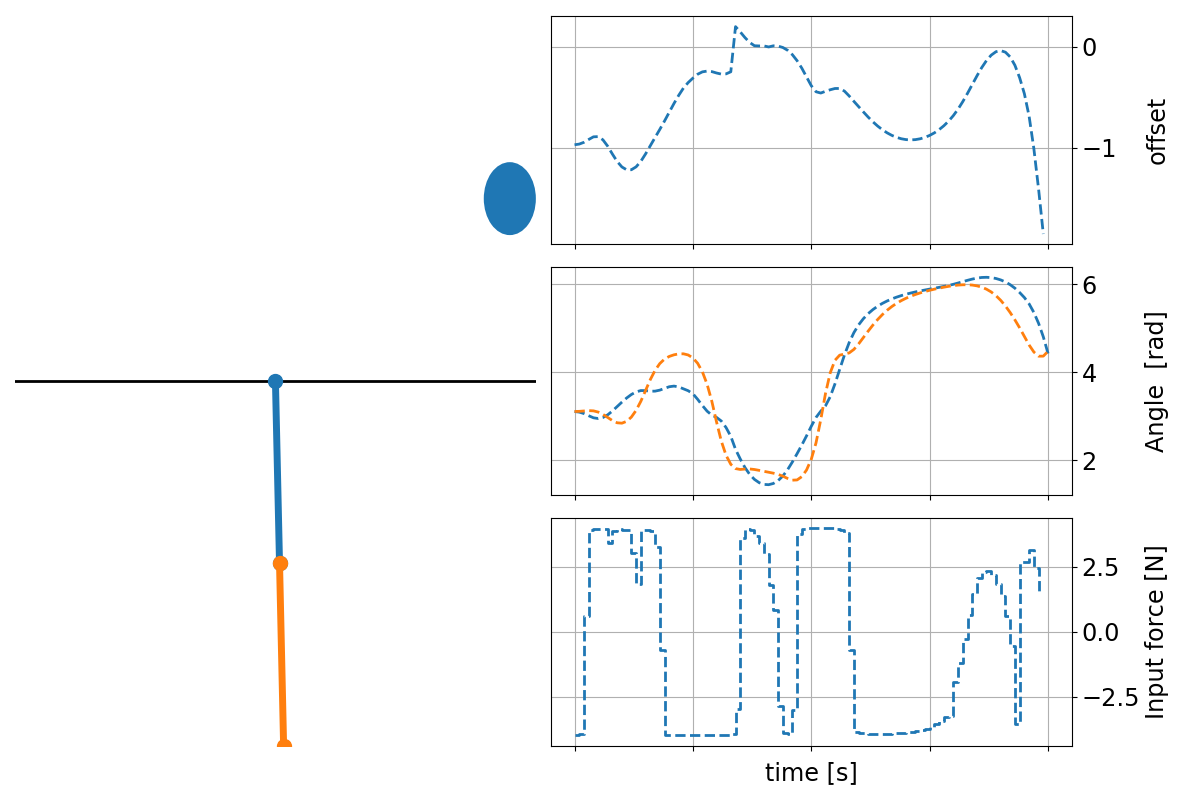

In [54]:
line1, line2 = pendulum_bars(x0)
bar1[0].set_data(line1[0],line1[1])
bar2[0].set_data(line2[0],line2[1])
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig